In [54]:

import pandas as pd
import dotenv
from dotenv import load_dotenv
from IPython.display import Image, display, Audio, Markdown
from pydantic import BaseModel
import base64
import json
from fastapi import FastAPI


#### Load env 

In [6]:
load_dotenv()

True

#### Set Open AI Key

In [7]:
from openai import OpenAI 
import os

## Set the API key and model name
MODEL="gpt-4o-mini"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as an env var>"))

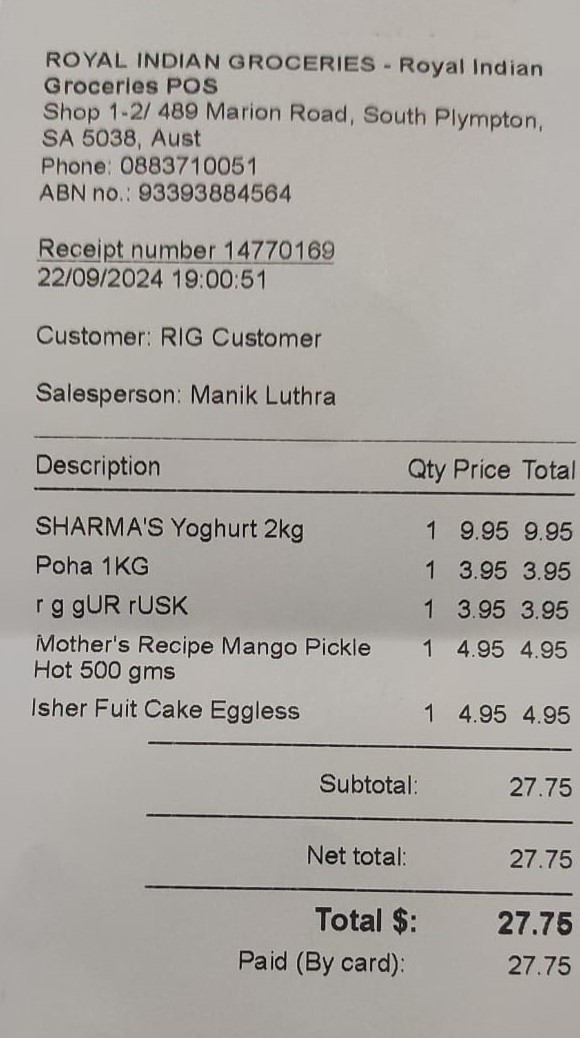

In [23]:
IMAGE_PATH = "../data/purchase_receipt.jpg"
display(Image(IMAGE_PATH))

#### Encode Image

In [24]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

In [47]:
base64_image

'/9j/4AAQSkZJRgABAQEAkACQAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAQOAkQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD6VnIa4dgQee1J1pnTccYyelPH3c1iahxS8UgxS8UmAcUcUcUcUgDijiiigA4o4oo4oAOKTApeKOKAGmlX60cetHFACH65prU49aGQ5+9igBgzjkYpOvNSEe9M27aAFyN2T+VDNxkDNGB3oI+Xg0BqN2+tJjFOzmjbnmkwGUo

#### Get Structured data from GPT-4o

In [31]:
response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "system",
      "content": "If the image is a receipt, output store, purchase date, items, abn, phone,  and total as JSON. If it's not a receipt, ask for a receipt."
    },
    {
      "role": "user",
      "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/png;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  temperature=0.0,
  response_format={ "type": "json_object" }
)

print(response.choices[0].message.content)

{
  "store": "ROYAL INDIAN GROCERIES - Royal Indian Groceries POS",
  "address": "Shop 1-2/ 489 Marion Road, South Plympton, SA 5038, Aust",
  "phone": "0883710051",
  "ABN": "93393884564",
  "receipt_number": "14770169",
  "date": "22/09/2024",
  "time": "19:00:51",
  "customer": "RIG Customer",
  "salesperson": "Manik Luthra",
  "items": [
    {
      "description": "SHARMA'S Yoghurt 2kg",
      "quantity": 1,
      "price": 9.95,
      "total": 9.95
    },
    {
      "description": "Poha 1KG",
      "quantity": 1,
      "price": 3.95,
      "total": 3.95
    },
    {
      "description": "r g gUR rUSK",
      "quantity": 1,
      "price": 3.95,
      "total": 3.95
    },
    {
      "description": "Mother's Recipe Mango Pickle Hot 500 gms",
      "quantity": 1,
      "price": 4.95,
      "total": 4.95
    },
    {
      "description": "Isher Fuit Cake Eggless",
      "quantity": 1,
      "price": 4.95,
      "total": 4.95
    }
  ],
  "subtotal": 27.75,
  "net_total": 27.75,
  "tot

#### Control json using function call

In [28]:
function_call = [
  {
    "type": "function",
    "function": {
      "name": "itemize_receipt",
      "description": "Itemize a receipt from an image",
      "parameters": {
        "type": "object",
        "properties": {
          "vendor": {
            "type": "string",
            "description": "Name of vendor",
          },
          "date": {
            "type": "string",
            "format": "date",
            "description": "Date of purchase",
          },
          "items": {
            "type": "array",
            "items": {
              "type": "object",
              "properties": {
                  "name": {
                    "type": "string",
                    "description": "Name of item",
                  },
                  "price": {
                    "type": "number",
                    "description": "Price of item",
                  },
                  "quantity": {
                    "type": "integer",
                    "description": "Quantity of item",
                  },
                  "category": {
                    "type": "string",
                    "description": "Category of item",
                    "enum": ["take-out", "meal", "groceries", "clothing", "electronics", "supplies", "other"],
                  },
              },
            },
            "description": "List of items purchased",
          },
          "payment_method": {
            "type": "string",
            "description": "Payment method",
            "enum": ["cash", "credit", "debit", "mobile", "other"],
          },
        },
        "required": ["vendor","date","items","payment_method"],
      },
    }
  }
]

In [32]:
# Use IPython.display.JSON for easier to read JSON output.
from IPython.display import JSON

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "system", 
      "content": "If the image is a receipt, process the data. If it's not a receipt, ask user for a receipt."
    },
    {
      "role": "user", 
      "content": [
                      {
                        "type": "image_url", "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"}
                      }
                ]
    },
  ],
  tools=function_call, # customized json defined in function_call above
  tool_choice="auto",  # 
  temperature=0.0,
)

print(response)
# Parse the JSON data from the response
receipt_data = json.loads(response.choices[0].message.tool_calls[0].function.arguments)

# Display the JSON data
JSON(receipt_data, expanded=True)

ChatCompletion(id='chatcmpl-AAEjNofQEFSHeR3v0wUWq2uj1bW8W', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_JZQrvSIPn3nFmRCk86X2c0ra', function=Function(arguments='{"vendor":"Royal Indian Groceries","date":"2024-09-22","items":[{"name":"SHARMA\'S Yoghurt 2kg","price":9.95,"quantity":1,"category":"groceries"},{"name":"Poha 1KG","price":3.95,"quantity":1,"category":"groceries"},{"name":"r g gUR rUSK","price":3.95,"quantity":1,"category":"groceries"},{"name":"Mother\'s Recipe Mango Pickle Hot 500 gms","price":4.95,"quantity":1,"category":"groceries"},{"name":"Isher Fruit Cake Eggless","price":4.95,"quantity":1,"category":"groceries"}],"payment_method":"credit"}', name='itemize_receipt'), type='function')], refusal=None))], created=1727003269, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_3537616b13', usage=Co

<IPython.core.display.JSON object>

In [37]:
data = JSON(receipt_data, expanded=False)

In [42]:
receipt_data['items']

[{'name': "SHARMA'S Yoghurt 2kg",
  'price': 9.95,
  'quantity': 1,
  'category': 'groceries'},
 {'name': 'Poha 1KG', 'price': 3.95, 'quantity': 1, 'category': 'groceries'},
 {'name': 'r g gUR rUSK',
  'price': 3.95,
  'quantity': 1,
  'category': 'groceries'},
 {'name': "Mother's Recipe Mango Pickle Hot 500 gms",
  'price': 4.95,
  'quantity': 1,
  'category': 'groceries'},
 {'name': 'Isher Fruit Cake Eggless',
  'price': 4.95,
  'quantity': 1,
  'category': 'groceries'}]

In [73]:
from datetime import date

expenses_df = pd.DataFrame()
expenses_df
new_rows = []
for item in receipt_data['items']:

  print(f"Adding item: {item['name']}")
  new_row = {
        "Date": receipt_data.get("date", date.today().isoformat()),
        "Vendor": receipt_data.get("vendor", ""),
        "Name": item['name'],
        "Quantity": item.get("quantity", 1),
        "Price": item.get("price", 0),
  }
  new_rows.append(new_row)

# Convert the list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the new rows DataFrame to the existing expenses DataFrame
if expenses_df.empty:
  expenses_df = new_rows_df
else:
  expenses_df = pd.concat([expenses_df, new_rows_df], ignore_index=True)

expenses_df.to_csv("../output/expenses.csv", index=False)

Adding item: SHARMA'S Yoghurt 2kg
Adding item: Poha 1KG
Adding item: r g gUR rUSK
Adding item: Mother's Recipe Mango Pickle Hot 500 gms
Adding item: Isher Fruit Cake Eggless
